## CCLUE 古文语言理解

### https://cclue.top/guwen-models.html
<img src='./images/guwen-models.png'></img>

# 地理解析 Geoparsing with Python

从文本中解析出地名，并在地图上绘制出解析出的地点，这个过程称之为Geoparsing，包括：
- 从文本中找出地名
- 找出地名所对应的经纬度坐标
这个过程与Toponym resolution有些类似，但Geoparsing更为复杂一些，Toponym，还有一个环节，即确定一个地名实际指的地方，会直接导致下一个环节的“编码”过程（geocoding）。一旦将地名与其对应的经纬度坐标完成匹配，这些地名就可以绘制到电子地图上。

## 第一个例子：英文地名解析
马克吐温的小说The Innocents Abroad《傻子路行》（《新朝圣者的进步》）是1869年马克吐温出版的一本旅行书，幽默地记载了1867年马克吐温所称的“伟大愉悦之旅”（Great Pleasure Excursion），与一群美国游客一起乘坐包机前往奎克称Quaker City，穿越欧洲和圣地。这本书是马克·吐温的第一部旅行文学著作。当时作者是《加利福尼亚大地报》的记者，报社派他取道巴拿马运河从旧金山到纽约市，作巡回记者，这次经历促成了《傻子旅行》的诞生。该书是马克·吐温一生中最畅销的作品，也是至今旅行作品中最畅销的著作。

其中有大量的地名，本课第一个例子就是从小说文本中提取出这些地名，并在得到地名的经纬度坐标之后，将这些地名绘制到电子地图上，并在Jupyter Notebook中呈现出来。

<img src="./images/马克吐温.png"></img>

## 第二个例子：中文古地名解析
借助CBDB的地名表来将古文中的中国古地名提取出来，获取其经纬度坐标，并在地图上绘制。

- 测试数据：《稀見地方志提要》
- 文本地址：
    - https://ctext.org/wiki.pl?if=en&res=429409
    - https://www.zhonghuadiancang.com/leishuwenji/xijiandifangzhitiyao/

<img src="./images/希见地方志提要.jpeg"></img>


## 导入所需要的包
- matplotlib.pyplot: 绘图
- pandas：Python中的数据分析
- geopandas
    - GeoPandas是一个开源项目，它的目的是使得在Python下更方便的处理地理空间数据。GeoPandas扩展了pandas的数据类型，允许其在几何类型上进行空间操作。几何操作由shapely执行。GeoPandas进一步依赖于fiona进行文件存取和descartes，matplotlib进行绘图。 
- urllib：访问网页数据
- geotext：解析文本中的地名
- geopy
    - geopy是一个关于地理编码的python库。主要有以下几个功能：(需要联网)
        - 地理编码：将字符串转换为地理位置
        - 逆地理编码：用于将地理坐标转换为具体地址
        - 计算两个点的距离：经纬度距离和球面距离


In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import geopandas as gpd

from urllib import request
from geotext import GeoText

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

from shapely.geometry import Point, Polygon
import descartes

## 使用urlilib的request从古登堡数据库访问需要的文件

从Gutenberg Project获得《傻子旅行》的英文全文（“古腾堡计划”http://www.gutenberg.org）

文件格式：text

全文总计：11145406个字符

In [8]:
url = "http://www.gutenberg.org/files/3176/3176-0.txt"
response = request.urlopen(url)
raw = response.read().decode('utf8')
print(f'{type(raw)}, \n{len(raw)}, \n{raw[:501]}')

<class 'str'>, 
1145406, 
﻿Project Gutenberg's The Innocents Abroad, by Mark Twain (Samuel Clemens)

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: The Innocents Abroad

Author: Mark Twain (Samuel Clemens)

Release Date: August 18, 2006 [EBook #3176]
Last Updated: February 23, 2018

Language: English


## 使用GeoText识别英文文本中的地名

注意：没有去掉重复的城市名

In [15]:
places = GeoText('Beijing hello I am from New York, what about you? I am from London. He is from Paris')
places = list(places.cities)
places

['Beijing', 'New York', 'London', 'Paris']

In [19]:
places = GeoText(raw) # 解析文本中的地理信息实体
cities = list(places.cities) # 

cities

['Tangier',
 'Paris',
 'Temple',
 'Como',
 'Garibaldi',
 'Rome',
 'Roman',
 'Naples',
 'Naples',
 'Bay',
 'Smyrna',
 'Ferguson',
 'Jacksonville',
 'Jericho',
 'Fountain',
 'Paradise',
 'Damascus',
 'George',
 'Pen',
 'Palestine',
 'Tiberias',
 'Nazareth',
 'Godfrey',
 'David',
 'Jericho',
 'Bethany',
 'March',
 'Palestine',
 'Holiday',
 'San Francisco',
 'New York',
 'New York',
 'York',
 'Paris',
 'Genoa',
 'Genoa',
 'Columbus',
 'Verona',
 'Venice',
 'Parma',
 'Correggio',
 'Bologna',
 'Florence',
 'Florence',
 'Pisa',
 'Lucca',
 'Roman',
 'Florence',
 'Naples',
 'Rome',
 'Garibaldi',
 'Rome',
 'Naples',
 'Palermo',
 'Naples',
 'Athens',
 'Messina',
 'Piraeus',
 'Athens',
 'Bay',
 'Corinth',
 'Athens',
 'Balaklava',
 'Troy',
 'Asia',
 'Smyrna',
 'Asia',
 'Beirut',
 'Damascus',
 'Jerusalem',
 'Tiberias',
 'Nazareth',
 'Bethany',
 'Bethlehem',
 'Beirut',
 'Damascus',
 'Tiberias',
 'Alexandria',
 'Alexandria',
 'Cairo',
 'Memphis',
 'Cagliari',
 'Palma',
 'Parma',
 'Valencia',
 'Duncan'

In [20]:
#cities = list(set(cities))
len(cities)

1091

## 地理编码

OpenStreetMap（OSM）是一个类似于Wikipedia模式的地图系统：免费、人人可编辑

OSM的工具Nominatim可以根据提供的城市名来返回该城市的经纬度坐标，因此前面提取出的城市名可以使用Nominatim转换为经纬度坐标。

Geopy包将Nominatim的功能进行了封装，所以导入的包的时候使用的是：from geopy.geocoders import Nominatim

为之设置的执行时间为2秒，因为是通过网络调用的，所以设置的时间稍微长一点儿。

In [21]:
geolocator = Nominatim(user_agent="http", timeout=2)
lat_lon = []
for city in cities:
    try:
        location = geolocator.geocode(city)
        if location:
            print(location.latitude, location.longitude)
            lat_lon.append(location)
    except GeocoderTimedOut as e:
        print("Error: geocode failed on input %s with message %s" % (city, e))
lat_lon

35.777103 -5.803792
48.8588897 2.3200410217200766
31.098207 -97.3427847
45.939475900000005 9.149410145408947
-29.2562253 -51.5269167
41.8933203 12.4829321
48.836297599999995 1.047626206618487
40.8359336 14.2487826
40.8359336 14.2487826
47.293159 5.719928515655752
38.4147331 27.1434119
38.744707 -90.3038975
30.3321838 -81.655651
31.855991 35.4598851
38.70437675 -104.71025954018519
36.1150858 -115.173414
33.5130695 36.3095814
-33.964444 22.459722
18.6973659 73.13672046831282
31.462420950000002 34.262716572130714
32.7938522 35.5328566
32.7066301 35.3048161
38.9556031 -90.1867765
8.4949423 -82.48261591569641
31.855991 35.4598851
40.2683344 -94.0282861
48.0578573 7.7790038
31.462420950000002 34.262716572130714
28.187755 -82.74160807073932
37.7790262 -122.419906
40.7127281 -74.0060152
40.7127281 -74.0060152
53.9590555 -1.0815361
48.8588897 2.3200410217200766
44.40726 8.9338624
44.40726 8.9338624
39.9622601 -83.0007065
45.4384958 10.9924122
45.4371908 12.3345898
44.8013678 10.3280833
44.77056

45.4371908 12.3345898
31.199004 29.894378
45.4371908 12.3345898
45.4371908 12.3345898
45.4371908 12.3345898
45.4371908 12.3345898
45.4371908 12.3345898
45.4371908 12.3345898
45.4371908 12.3345898
-29.6860512 -53.8069214
34.1064001 -117.3703235
45.4371908 12.3345898
-33.964444 22.459722
37.1960735 -101.8099541
42.3602534 -71.0582912
48.8588897 2.3200410217200766
48.8588897 2.3200410217200766
45.4371908 12.3345898
-29.6860512 -53.8069214
45.4371908 12.3345898
45.4371908 12.3345898
45.4371908 12.3345898
45.4371908 12.3345898
45.4371908 12.3345898
39.5695818 2.6500745
45.4371908 12.3345898
8.4949423 -82.48261591569641
39.9622601 -83.0007065
35.1770785 -94.2654285
51.7069911 46.7483653
35.1159532 -80.7224386
45.4371908 12.3345898
45.4371908 12.3345898
45.4371908 12.3345898
45.4371908 12.3345898
44.40726 8.9338624
45.939475900000005 9.149410145408947
45.4371908 12.3345898
45.4371908 12.3345898
45.4371908 12.3345898
45.4371908 12.3345898
44.4938203 11.3426327
43.9740957 10.868708114044026
43.

31.098207 -97.3427847
30.3321838 -81.655651
31.855991 35.4598851
27.7198095 56.335807
40.881735899999995 40.27544376928809
40.881735899999995 40.27544376928809
31.855991 35.4598851
48.8588897 2.3200410217200766
31.098207 -97.3427847
31.098207 -97.3427847
26.9342246 -80.0942087
26.9342246 -80.0942087
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
36.4884715 -79.7667026
36.4884715 -79.7667026
36.1150858 -115.173414
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
41.8933203 12.4829321
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
51.2086975 89.2343748
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
33.5130695 36.3095814
21.420847 39.8

31.462420950000002 34.262716572130714
32.7066301 35.3048161
31.855991 35.4598851
31.7043556 35.2061876
40.2683344 -94.0282861
48.836297599999995 1.047626206618487
31.462420950000002 34.262716572130714
31.462420950000002 34.262716572130714
38.744707 -90.3038975
31.199004 29.894378
33.5130695 36.3095814
48.8588897 2.3200410217200766
42.3602534 -71.0582912
31.199004 29.894378
40.7127281 -74.0060152
53.4071991 -2.99168
31.199004 29.894378
30.0443879 31.2357257
45.7162129 -94.0481042
38.7604815 -92.5617875
38.4147331 27.1434119
40.881735899999995 40.27544376928809
40.881735899999995 40.27544376928809
40.881735899999995 40.27544376928809
40.881735899999995 40.27544376928809
40.881735899999995 40.27544376928809
36.4884715 -79.7667026
35.1490215 -90.0516285
37.2638324 -122.0230146
38.8950368 -77.0365427
29.9499323 -90.0701156
32.4078632 -87.0207473
30.0443879 31.2357257
21.420847 39.826869
31.199004 29.894378
41.8933203 12.4829321
31.199004 29.894378
36.7753606 3.0601882
39.2169525 9.1128513
3

[Location(Tanger طنجة, pachalik de Tanger طنجة, Préfecture de Tanger-Assilah عمالة طنجة-أصيلة, Tanger-Tétouan-Al Hoceima ⵟⴰⵏⵊ-ⵟⵉⵜⴰⵡⵉⵏ-ⵍⵃⵓⵙⵉⵎⴰ طنجة تطوان الحسيمة, Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب, (35.777103, -5.803792, 0.0)),
 Location(Paris, Île-de-France, France métropolitaine, France, (48.8588897, 2.3200410217200766, 0.0)),
 Location(Temple, Bell County, Texas, United States, (31.098207, -97.3427847, 0.0)),
 Location(Como, Lombardia, Italia, (45.939475900000005, 9.149410145408947, 0.0)),
 Location(Garibaldi, Região Geográfica Imediata de Bento Gonçalves, Região Geográfica Intermediária de Caxias do Sul, Rio Grande do Sul, Região Sul, 95720-000, Brasil, (-29.2562253, -51.5269167, 0.0)),
 Location(Roma, Roma Capitale, Lazio, 00100, Italia, (41.8933203, 12.4829321, 0.0)),
 Location(Roman, Mesnils-sur-Iton, Bernay, Eure, Normandie, France métropolitaine, 27240, France, (48.836297599999995, 1.047626206618487, 0.0)),
 Location(Napoli, Campania, Italia, (40.8359336, 14.2487826, 0.0)),
 Location(Nap

In [1]:
print(lat_lon[0])

NameError: name 'lat_lon' is not defined

## 将城市名和对应的经纬度坐标放到Pandas dataframe中进行存储和管理。

In [20]:
df = pd.DataFrame(lat_lon, columns=['City Name', 'Coordinates'])
df.head(7)

,City Name,Coordinates
0,"Tanger طنجة, pachalik de Tanger طنجة, Préfectu...","(35.777103, -5.803792)"
1,"Paris, Île-de-France, France métropolitaine, F...","(48.8588897, 2.3200410217200766)"
2,"Temple, Bell County, Texas, United States","(31.098207, -97.3427847)"
3,"Como, Lombardia, Italia","(45.939475900000005, 9.149410145408947)"
4,"Garibaldi, Região Geográfica Imediata de Bento...","(-29.2562253, -51.5269167)"
5,"Roma, Roma Capitale, Lazio, 00100, Italia","(41.8933203, 12.4829321)"
6,"Roman, Mesnils-sur-Iton, Bernay, Eure, Normand...","(48.836297599999995, 1.047626206618487)"


## 数据转换
现在经纬度坐标的格式是元组（tuple），我们需要将其转换为Point类型，因为每个城市在地图上使用一个点表示。

使用Python包Shapely实现：遍历包含经纬度坐标元组的Dataframe Series，将其转换为Point，并调换经度和纬度的位置。

In [21]:
geometry = [Point(x[1], x[0]) for x in df['Coordinates']]
geometry[:7]

## 将pandas转换为geopandas


In [22]:
## coordinate system I'm using
crs = {'init': 'epsg:4326'}

## convert df to geo df
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
geo_df.head()

/home/guangwei/anaconda3-2021/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,City Name,Coordinates,geometry
0,"Tanger طنجة, pachalik de Tanger طنجة, Préfectu...","(35.777103, -5.803792)",POINT (-5.80379 35.77710)
1,"Paris, Île-de-France, France métropolitaine, F...","(48.8588897, 2.3200410217200766)",POINT (2.32004 48.85889)
2,"Temple, Bell County, Texas, United States","(31.098207, -97.3427847)",POINT (-97.34278 31.09821)
3,"Como, Lombardia, Italia","(45.939475900000005, 9.149410145408947)",POINT (9.14941 45.93948)
4,"Garibaldi, Região Geográfica Imediata de Bento...","(-29.2562253, -51.5269167)",POINT (-51.52692 -29.25623)


## 地图上呈现上述地点

1. 下载shape file
    - Shapefile是一种比较原始的矢量数据存储方式，它仅仅能够存储几何体的位置数据，而无法在一个文件之中同时存储这些几何体的属性数据。 因此，Shapefile还必须附带一个二维表用于存储Shapefile中每个几何体的属性信息。 
    - Shapefile中许多几何体能够代表复杂的地理事物，并为他们提供强大而精确的计算能力。 Shapefile文件指的是一种文件存储的方法，实际上该种文件格式是由多个文件组成的。
    - 要组成一个Shapefile，有三个文件是必不可少的，它们分别是".shp", ".shx"与 ".dbf"文件。
2. 设置绘图区域

3. 将坐标点绘制到地图上

<AxesSubplot:>

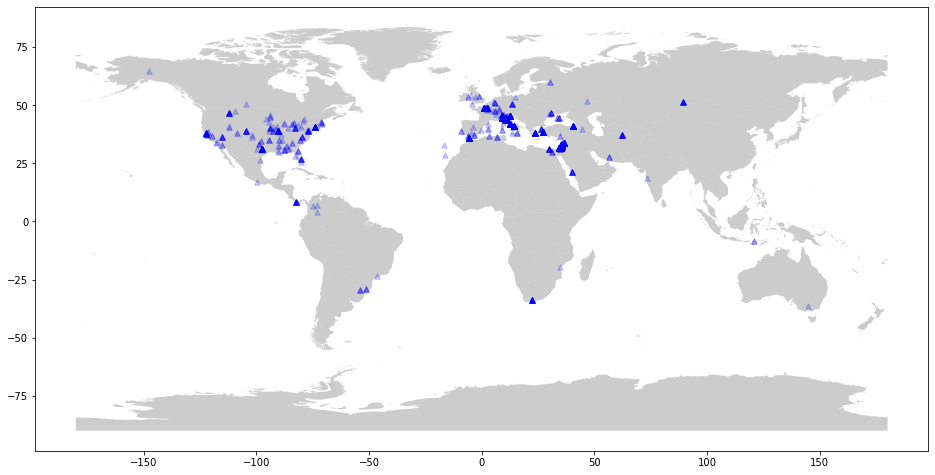

In [25]:
## world map .shp file I downloaded
countries_map =gpd.read_file('./Countries_WGS84/Countries_WGS84.shp')
f, ax = plt.subplots(figsize=(16, 16))
countries_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df['geometry'].plot(ax=ax, markersize = 30, color = 'b', marker = '^', alpha=.2)

# 使用jieba/jiayan提取古文中的地名
1. jieba
安装jieba： pip install jieba

使用paddle模式：pip install paddlepaddle

2. jiayan安装方法：
- pip install jiayan
- pip install https://github.com/kpu/kenlm/archive/master.zip

In [3]:
import jieba
import paddle

paddle.enable_static()
jieba.enable_paddle()# 启动paddle模式。 0.40版之后开始支持，早期版本不支持
strs=["我来到北京清华大学","乒乓球拍卖完了","中国科学技术大学", "清滕天绶纂修天绶辽阳人荫生由广东潮州府同知升汉中府知府"]
for str in strs:
    seg_list = jieba.cut(str,use_paddle=True) # 使用paddle模式
    print("Paddle Mode: " + '/'.join(list(seg_list)))

seg_list = jieba.cut("我来到北京清华大学", cut_all=True)
print("Full Mode: " + "/ ".join(seg_list))  # 全模式

seg_list = jieba.cut("我来到北京清华大学", cut_all=False)
print("Default Mode: " + "/ ".join(seg_list))  # 精确模式

seg_list = jieba.cut("他来到了网易杭研大厦")  # 默认是精确模式
print(", ".join(seg_list))

seg_list = jieba.cut_for_search("小明硕士毕业于中国科学院计算所，后在日本京都大学深造")  # 搜索引擎模式
print(", ".join(seg_list))

Paddle enabled successfully......
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


Paddle Mode: 我/来到/北京清华大学
Paddle Mode: 乒乓球/拍卖/完/了
Paddle Mode: 中国科学技术大学
Paddle Mode: 清滕天绶纂修天绶/辽阳/人荫/生由/广东潮州府同知升汉中府/知府


Loading model cost 0.684 seconds.
Prefix dict has been built successfully.


Full Mode: 我/ 来到/ 北京/ 清华/ 清华大学/ 华大/ 大学
Default Mode: 我/ 来到/ 北京/ 清华大学
他, 来到, 了, 网易, 杭研, 大厦
小明, 硕士, 毕业, 于, 中国, 科学, 学院, 科学院, 中国科学院, 计算, 计算所, ，, 后, 在, 日本, 京都, 大学, 日本京都大学, 深造


## 从CBDB地名表中获取古代地名

### 定义一个函数来判定一个词是否为地名

In [4]:
placenames = []
with open('./data/placenames.txt', 'r', encoding='utf-8') as f:
    txt = f.read()


placenames = txt.split('\n')
placenames = placenames[:-1]
print(len(placenames))

def is_placename(placename):
    if placename in placenames:
        return True
    else:
        return False
print(placenames[0])
print(len(placenames[0]))

12366
荊州右衛
4


### 实例1：列出古文文本中所有的地名

In [24]:
jieba.load_userdict("./data/placenames.txt")
text = '清滕天綬纂修天綬遼陽人蔭生由廣東潮州府同知升漢中府知府漢南即漢中府其名始於秦，至明始置府，領邑十二府志創於明嘉靖二十三年知府張良知修漢中府志十卷清順治十三年知府馮達道又重修府志六卷是編天綬延邑人和鹽鼎採輯順治十三年後三十餘年之事乃合舊志共編為二十四卷卷帙雖大增於前而只補藝文居多事物所增無幾其書體裁總分為六類曰輿地志曰建置志曰食貨志曰秩官志曰人物志曰藝文志輿地志有僭亂歷代得失大略明末流寇記略三篇不入藝文於志例殊若不合餘類亦子目冗雜體例有欠嚴慎'
#text='明呂鵬雲、方時化纂修。鵬云號溟南，直棣東明縣人；明萬歷四十四年進士，授任巨野知縣，官至御史。時化歙縣人，舉人，天啟初任巨野知縣。按舊序《巨野縣志》始於嘉靖丙午知縣江廷藻，萬歷庚寅知縣殷如孝重修。此志為鵬雲增續前志萬歷庚寅後三十餘年之事，纂成此稿，以奉召北上。及時化任邑令取其成帙，仍其體要，以芟削潤色，刻成於天啟癸亥。按此書卷前有天啟三年鵬云及時化二序，書內分方輿、山川、建置、食貨、學校、秩祀、職官、口碑、選舉、人物、列女、藝文、金石、風俗、雜稽十五門，職官、口碑、選舉，間有崇禎時補版。口碑者為宦跡傳，立名偏好詭異。風俗記禮俗人情飲食令節民事甚詳，俾此可考巨野人民明時之風習。按巨野為春秋時魯之武城縣，曾子出生、子游所宰之地。哀公十四年春西狩獲麟於此，孔子往觀之曰：「麟也，胡為乎來哉？」因泣嘆以為不祥。此志古跡載縣境有獲麟塚、麒麟台、瑞嶙寺諸勝跡。'
words = [item for item in jieba.cut(text)]
places = [p for p in words if is_placename(p)]
#print(words)
print(places)

['遼陽', '潮州府', '漢中府', '漢南', '漢中府', '漢中府']


In [25]:
text2 = "清趙世震修，汪澤延纂。世震遼東人，康熙間漢陰知縣。澤延漢陰縣人，貢生。考漢陰縣志創於成化十六年知縣張大綸，萬歷四十七年知縣張啟蒙，崇禎十五年知縣張鵬翱，皆有重修。此志為續崇禎十五年後之事而重纂，其志總分輿地、建置、田賦、官師、人物、藝文六門，子目凡三十一，附目七，體例尚為簡核。按輿地沿革謂：「漢陰為漢時安陽縣地，晉改曰安康；北魏改寧都，隋複改安康，唐始名漢陰。」所敘沿革，徵引傍考，不著出處，殊難使信。卷前有八景，首列鳳山疊翠，鳳山即鳳凰山，在縣南若列屏然；東西綿亙二百餘里，宛有鳳翔千仞之勢。輿地山川謂，鳳凰山在縣南二十五里，有峰如鳳因名；山頂有鳳凰池、仙女池。藝文志載陳典《鳳凰山紀》，稱此山上有萬仞芙蓉，朵朵活潑，直逼青天；下有漢水紆迥，淙淙泉石。茲觀此志八景鳳山之圖，及陳典形容之辭，則鳳凰山果不愧為漢陰之名勝也。"
words2 = [item for item in jieba.cut(text2)]
places2 = [p for p in words2 if is_placename(p)]
print(places2)

['遼東', '漢陰', '漢陰', '漢陰', '漢陰', '安陽', '安康', '寧都', '安康', '漢陰', '鳳山', '鳳山', '鳳凰', '鳳翔', '鳳凰', '鳳凰', '鳳凰', '芙蓉', '鳳山', '鳳凰', '漢陰']


### 甲言

In [8]:
from jiayan import load_lm
from jiayan import CharHMMTokenizer

text = '清滕天綬纂修天綬遼陽人蔭生由廣東潮州府同知升漢中府知府漢南即漢中府其名始於秦，至明始置府，領邑十二府志創於明嘉靖二十三年知府張良知修漢中府志十卷清順治十三年知府馮達道又重修府志六卷是編天綬延邑人和鹽鼎採輯順治十三年後三十餘年之事乃合舊志共編為二十四卷卷帙雖大增於前而只補藝文居多事物所增無幾其書體裁總分為六類曰輿地志曰建置志曰食貨志曰秩官志曰人物志曰藝文志輿地志有僭亂歷代得失大略明末流寇記略三篇不入藝文於志例殊若不合餘類亦子目冗雜體例有欠嚴慎'

lm = load_lm('../jiayan_models/jiayan.klm')
tokenizer = CharHMMTokenizer(lm)
print(list(tokenizer.tokenize(text)))

['清', '滕', '天', '綬', '纂修', '天', '綬', '遼', '陽', '人', '蔭', '生', '由', '廣', '東', '潮州', '府', '同知', '升', '漢', '中', '府', '知府', '漢', '南', '即', '漢', '中', '府', '其', '名', '始', '於', '秦', '，', '至', '明', '始置', '府', '，', '領', '邑', '十二', '府志', '創', '於', '明', '嘉靖', '二十', '三年', '知府', '張', '良知', '修', '漢', '中', '府', '志十卷', '清', '順', '治', '十', '三年', '知府', '馮', '達', '道', '又', '重修', '府', '志六卷', '是', '編', '天', '綬', '延', '邑人', '和', '鹽', '鼎', '採', '輯', '順', '治', '十', '三年', '後', '三十', '餘', '年', '之', '事', '乃', '合', '舊', '志', '共', '編', '為', '二十', '四卷', '卷帙', '雖', '大', '增', '於', '前', '而', '只', '補', '藝', '文', '居多', '事物', '所', '增', '無', '幾', '其', '書', '體', '裁', '總', '分', '為', '六', '類', '曰', '輿', '地', '志', '曰', '建置', '志', '曰', '食', '貨', '志', '曰', '秩', '官', '志', '曰', '人物', '志', '曰', '藝', '文', '志', '輿', '地', '志', '有', '僭', '亂', '歷', '代', '得', '失', '大略', '明', '末流', '寇', '記', '略', '三篇', '不', '入', '藝', '文', '於', '志', '例', '殊', '若', '不', '合', '餘', '類', '亦', '子', '目', '冗', '雜', '體', '例', '有', '欠', '嚴', '慎']


In [9]:
from jiayan import WordNgramTokenizer

tokenizer = WordNgramTokenizer()
print(list(tokenizer.tokenize(text)))

['清', '滕', '天', '綬', '纂修', '天', '綬', '遼', '陽', '人', '蔭', '生', '由', '廣', '東', '潮州', '府', '同', '知', '升', '漢', '中', '府', '知', '府', '漢', '南', '即', '漢', '中', '府', '其', '名', '始', '於', '秦', '，', '至', '明', '始', '置', '府', '，', '領', '邑', '十二', '府', '志', '創', '於', '明', '嘉靖', '二十', '三年', '知', '府', '張', '良', '知', '修', '漢', '中', '府', '志', '十', '卷', '清', '順', '治', '十', '三年', '知', '府', '馮', '達', '道', '又', '重', '修', '府', '志', '六', '卷', '是', '編', '天', '綬', '延', '邑', '人', '和', '鹽', '鼎', '採', '輯', '順', '治', '十', '三年', '後', '三', '十', '餘', '年', '之', '事', '乃', '合', '舊', '志', '共', '編', '為', '二十', '四', '卷', '卷', '帙', '雖', '大', '增', '於', '前', '而', '只', '補', '藝', '文', '居', '多', '事', '物', '所', '增', '無', '幾', '其', '書', '體', '裁', '總', '分', '為', '六', '類', '曰', '輿', '地', '志', '曰', '建', '置', '志', '曰', '食', '貨', '志', '曰', '秩', '官', '志', '曰', '人', '物', '志', '曰', '藝', '文', '志', '輿', '地', '志', '有', '僭', '亂', '歷', '代', '得', '失', '大', '略', '明', '末', '流', '寇', '記', '略', '三', '篇', '不', '入', '藝', '文', '於', '志', '例', '殊', '若', 

In [14]:
from jiayan import load_lm
from jiayan import CRFPunctuator

text = '清滕天綬纂修天綬遼陽人蔭生由廣東潮州府同知升漢中府知府漢南即漢中府其名始於秦至明始置府領邑十二府志創於明嘉靖二十三年知府張良知修漢中府志十卷清順治十三年知府馮達道又重修府志六卷是編天綬延邑人和鹽鼎採輯順治十三年後三十餘年之事乃合舊志共編為二十四卷卷帙雖大增於前而只補藝文居多事物所增無幾其書體裁總分為六類曰輿地志曰建置志曰食貨志曰秩官志曰人物志曰藝文志輿地志有僭亂歷代得失大略明末流寇記略三篇不入藝文於志例殊若不合餘類亦子目冗雜體例有欠嚴慎'

lm = load_lm('../jiayan_models/jiayan.klm')
punctuator = CRFPunctuator(lm, '../jiayan_models/cut_model')
punctuator.load('../jiayan_models/punc_model')
print(punctuator.punctuate(text))

清滕天綬纂修，天綬遼陽人，蔭生由廣，東潮州府同知，升漢中府知府漢南即漢中府，其名始於秦，至明始置府，領邑十二，府志創於明，嘉靖二十三年，知府張良知修漢，中府志十卷，清順治，十三年，知府馮達道，又重修府志六卷，是編天綬延，邑人和鹽鼎，採輯順治，十三年，後三十餘年之事，乃合舊志，共編為二十四卷卷帙，雖大增於前，而只補藝文居多，事物所增無幾，其書體裁總，分為六類曰輿，地志曰：建置志曰：食貨志曰：秩官志曰：人物志曰：藝文志輿地志有僭，亂歷代得失，大略明末，流寇記略三篇，不入藝文於志例，殊若不合，餘類亦子目冗，雜體例有欠嚴慎。
